# Run QAOA

In [1]:
import json
import matplotlib.pyplot as plt

from qamoo.configs.configs import ProblemSpecification, QAOAConfig
from qamoo.utils.utils import compute_hypervolume_progress
from qamoo.algorithms.qaoa import *

from qiskit_aer import AerSimulator

from qiskit_ibm_runtime import QiskitRuntimeService

In [2]:
# define backend

# simulator
chi = 20
max_parallel_threads = 1
backend = AerSimulator(method='matrix_product_state', matrix_product_state_max_bond_dimension=chi, 
                       max_parallel_threads=max_parallel_threads)
backend.options.use_fractional_gates = False

# hardware
# service = QiskitRuntimeService()
# backend = service.backend("ibm_fez")

In [3]:
problem = ProblemSpecification()
problem.data_folder = './../data/'
problem.num_qubits = 42
problem.num_objectives = 3
problem.num_swap_layers = 0
problem.problem_id = 0
print(problem.problem_folder)

./../data/problems/42q/problem_set_42q_0s_3o_0/


In [4]:
parameter_origin = ProblemSpecification()
parameter_origin.data_folder = './../data/'
parameter_origin.num_qubits = 27
parameter_origin.num_objectives = problem.num_objectives
parameter_origin.num_swap_layers = problem.num_swap_layers
parameter_origin.problem_id = 0

print(parameter_origin)

ProblemSpecification(data_folder='./../data/', num_qubits=27, num_objectives=3, num_swap_layers=0, problem_id=0)


In [5]:
# define problem
problem = ProblemSpecification()
problem.data_folder = './../data/'
problem.num_qubits = 42
problem.num_objectives = 3
problem.num_swap_layers = 0
problem.problem_id = 0

# define algorithm configuration
config = QAOAConfig()
config.parameter_file = parameter_origin.problem_folder + 'JuliQAOA_angles.json'
config.p = 1
config.num_samples = 10
config.shots = 100
config.objective_weights_id = 0
config.backend_name = backend.name
config.initial_layout = None
config.run_id = f'test'
config.rep_delay = 0.0001
config.problem = problem

In [6]:
prepare_qaoa_circuits(config, backend, overwrite_results=True)

Folder exists!


In [7]:
# select best layout for 42-qubit circuits
if problem.num_qubits == 42 and backend.name != 'aer_simulator_matrix_product_state':

    # load parametrized circuit
    circuit_path = config.results_folder + 'parameterized_circuit.qpy'
    with open(circuit_path, 'rb') as f:
        # qc = pickle.load(f)
        qc = qpy.load(f)[0]
    
    # load potential initial layouts
    if backend.num_qubits == 156:
        with open(problem.data_folder + f'initial_layouts/{problem.num_qubits}q_heron_156.json', 'r') as f:
            initial_layouts = json.load(f)

    # transpile different layouts to backend
    qcs = []
    for initial_layout in tqdm(initial_layouts):
        preset_manager = generate_preset_pass_manager(backend=backend,
                                                      optimization_level=3,
                                                      initial_layout=initial_layout)
        qc_transpiled = preset_manager.run(qc)
        qcs += [qc_transpiled]
    
    # score results 
    fidelities = []
    measurement_fidelities = []
    all_avg_fidelities = []
    for i in range(len(initial_layouts)):
        initial_layout = initial_layouts[i]
        fidelity = 1
        measurement_fidelity = 1
        avg_fidelities = {}
        avg_counter = {}
        for d in qcs[i].data:
            if d.operation.name == 'measure':
                error = backend.properties().readout_error(d.qubits[0]._index)
                fidelity *= (1 - error)
                measurement_fidelity *= (1 - error)
                avg_fidelities['measure'] = avg_fidelities.get('measure', 1) * (1 - error)
                avg_counter['measure'] = avg_counter.get('measure', 0) + 1
            elif d.operation.name != 'barrier':
                name = d.operation.name
                qubits = [q._index for q in d.qubits]
                if name == 'rzz':
                    name = 'cz'
                error = backend.properties().gate_error(name, qubits)
                fidelity *= (1 - error)
                avg_fidelities[name] = avg_fidelities.get(name, 1) * (1 - error)
                avg_counter[name] = avg_counter.get(name, 0) + 1
            
        fidelities += [fidelity]
        measurement_fidelities += [measurement_fidelity]
        all_avg_fidelities += [{}]
        for k, v in avg_fidelities.items():
            all_avg_fidelities[-1][k] = np.round(v ** ( 1 / avg_counter[k] ), decimals=4)

    print('total fidelities:       ', np.round(fidelities, decimals=3))
    print('measurement fidelities: ', np.round(measurement_fidelities, decimals=3))

    i_opt = np.argmax(fidelities)
    print('max. fidelity:          ', np.round(fidelities[i_opt], decimals=6))
    config.initial_layout = initial_layouts[i_opt]
    for i in range(len(all_avg_fidelities)):
        if i != i_opt:
            print(all_avg_fidelities[i])
        else:
            print(all_avg_fidelities[i], '*')

In [8]:
with open(config.results_folder + 'estimated_fidelity.json', 'w') as f:
    try:
        json.dump(fidelities[i_opt], f)
    except:
        json.dump(1, f)

In [9]:
transpile_qaoa_circuits_parametrized(config, backend)

In [10]:
circuits = []
param_values = []
with open(config.results_folder + 'transpiled_parametrized_circuit.qpy', 'rb') as f:
    circuits += [qpy.load(f)[0]]
circuits[0].remove_final_measurements()
print(circuits[0].count_ops())
print('total depth =', circuits[0].depth(filter_function=lambda x: x.operation.name in ['cz', 'rzz', 'sx', 'rx', 'h']))
print('CZ depth    =', circuits[0].depth(filter_function=lambda x: x.operation.name in ['cz', 'rzz']))

OrderedDict([('rzz', 46), ('h', 42), ('rx', 42)])
total depth = 6
CZ depth    = 4


In [11]:
batch_execute_qaoa_circuits_parametrized([config], backend)

running with simulator


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 253.36it/s]

simulation time: 0.42251110076904297


In [12]:
if backend.name != 'aer_simulator_matrix_product_state':
    load_hardware_results([config], backend)

In [13]:
# define steps where to evaluate HV progress
step_size = 100
steps = range(0, config.total_num_samples+1, step_size)
print('steps =', list(steps))

steps = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]


In [14]:
compute_hypervolume_progress(problem.problem_folder, config.results_folder, steps)

evaluate samples objective... done.
1 / 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 50846.21it/s]


#NDP = 13
HV   =  17630.113010943172
2 / 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 107643.96it/s]


#NDP = 18
HV   =  17933.026479820055
3 / 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 119461.23it/s]


#NDP = 21
HV   =  18509.319868535196
4 / 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 76294.47it/s]


#NDP = 24
HV   =  20546.726931848305
5 / 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 61331.80it/s]


#NDP = 27
HV   =  20710.894267953972
6 / 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 74835.15it/s]


#NDP = 32
HV   =  20727.144454953486
7 / 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 58568.51it/s]


#NDP = 28
HV   =  21920.97396748041
8 / 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 58527.30it/s]


#NDP = 26
HV   =  22802.372333862175
9 / 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 71931.71it/s]


#NDP = 26
HV   =  22802.372333862175
10 / 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 82562.46it/s]

#NDP = 27
HV   =  22965.919947476195


In [15]:
x, y = config.progress_x_y()
print('Max. HV:', max(y))

Max. HV: 22965.919947476195


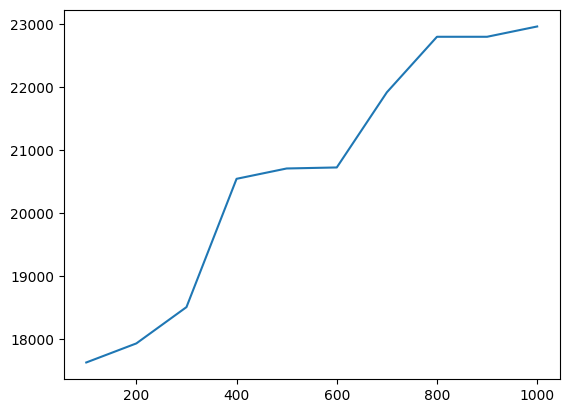

In [16]:
plt.plot(x, y)
plt.show()